In [1]:
#default_exp replan

In [3]:
#hide
from nbdev.showdoc import *

#%load_ext autoreload
#%autoreload 2

import sys
sys.path.insert(0, '..') #appends project root to path in order to import project packages since `noteboks_dev` is not on the root #appends project root to path in order to import project packages since `noteboks_dev` is not on the root


# RePLAN

In [1212]:
#export
import warnings

import numpy as np

from sklearn.utils.validation import check_is_fitted, check_array
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, KBinsDiscretizer, normalize
from sklearn.cluster import KMeans

from sklearn.base import BaseEstimator, TransformerMixin

try:
    from sparse_dot_topn import awesome_cossim_topn
except Exception as e:
    warn(f'could not load sparse_dot_topn: {e}')

# Util Functions

In [1213]:
#export

def sparse_dot_product(
    A,
    B,
    ntop = 1,
    lower_bound=0,
    use_threads=False,
    n_jobs=1,
    return_best_ntop=False,
    test_nnz_max=-1,
):
    
    '''
    flexible dot product function to work with or without sparse_dot_topn. In the absence of sparse_dot_topn, naive numpy dot product will be performed
    
    sparse_dot_topn.awesome_cossim_topn Docs:
    
    This function will return a matrix C in CSR format, where
    C = [sorted top n results > lower_bound for each row of A * B].
    If return_best_ntop=True then best_ntop
    (the true maximum number of elements > lower_bound per row of A * B)
    will also be returned in a tuple together with C as (C, best_ntop).

    Input:
        A and B: two CSR matrices
        ntop: top n results
        lower_bound: a threshold that the element of A*B must be greater than
        use_threads: use multi-thread or not
        n_jobs: number of thread, must be >= 1
        return_best_ntop: (default: False) if True, will return best_ntop together 
                          with C as a tuple: (C, best_ntop)

    Output:
        C: result matrix (returned alone, if return_best_ntop=False)
        best_ntop: The true maximum number of elements > lower_bound per row of 
                   A * B returned together with C as a tuple: (C, best_ntop). It is 
                   returned only if return_best_ntop=True.

    N.B. if A and B are not in CSR format, they will be converted to CSR
    '''
    
    if 'awesome_cossim_topn' in globals():
        dot = awesome_cossim_topn(
            A = A,
            B = B,
            ntop = ntop,
            lower_bound=lower_bound,
            use_threads=use_threads,
            n_jobs=n_jobs,
            return_best_ntop=return_best_ntop,
            test_nnz_max=test_nnz_max,
        )
    else:
        warn('sparse_dot_topn is not installed, this may cause performance issues in dot product calculations')
        dot = A@B
    
    return dot

## RobustKBinsDiscretizer

In [1214]:
#export
class RobustKBinsDiscretizer(KBinsDiscretizer):
    
    def __init__(
        self,
        n_bins=5,
        *,
        encode='onehot',
        strategy='quantile',
        dtype=None,
        handle_nan = 'handle', #error, handle, ignore        
    ):        
        self.encode = encode
        self.strategy = strategy
        self.dtype = dtype
        self.handle_nan = handle_nan      
        super().__init__(n_bins = n_bins,encode = encode,strategy = strategy,dtype = dtype)
        return
    
    
    def fit(self, X, y=None):
        """
        Fit the estimator.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Data to be discretized.
        y : None
            Ignored. This parameter exists only for compatibility with
            :class:`~sklearn.pipeline.Pipeline`.
        Returns
        -------
        self : object
            Returns the instance itself.
        """
        valid_handling = ["handle","error","ignore"]
        if not self.handle_nan in valid_handling:
            raise ValueError(f'handle_nan should be one of {valid_handling}, got {self.handle_nan}')
                        
        #make it robust to NaNs
        if self.handle_nan in ('handle','ignore'):
            X = self._validate_data(X, dtype="numeric", force_all_finite = "allow-nan")
        else:
            X = self._validate_data(X, dtype="numeric")
            
        supported_dtype = (np.float64, np.float32)
        if self.dtype in supported_dtype:
            output_dtype = self.dtype
        elif self.dtype is None:
            output_dtype = X.dtype
        else:
            raise ValueError(
                "Valid options for 'dtype' are "
                f"{supported_dtype + (None,)}. Got dtype={self.dtype} "
                " instead."
            )

        valid_encode = ("onehot", "onehot-dense", "ordinal")
        if self.encode not in valid_encode:
            raise ValueError(
                "Valid options for 'encode' are {}. Got encode={!r} instead.".format(
                    valid_encode, self.encode
                )
            )
        valid_strategy = ("uniform", "quantile", "kmeans")
        if self.strategy not in valid_strategy:
            raise ValueError(
                "Valid options for 'strategy' are {}. "
                "Got strategy={!r} instead.".format(valid_strategy, self.strategy)
            )

        n_features = X.shape[1]
        n_bins = self._validate_n_bins(n_features)

        bin_edges = np.zeros(n_features, dtype=object)
        for jj in range(n_features):
            column = X[:, jj]
            #make it Robust to NaNs excluding them from fit
            if self.handle_nan in ('handle','ignore'):
                column = column[~np.isnan(column.flatten())]
            else:
                column = column
            
            col_min, col_max = column.min(), column.max()

            if col_min == col_max:
                warnings.warn(
                    "Feature %d is constant and will be replaced with 0." % jj
                )
                n_bins[jj] = 1
                bin_edges[jj] = np.array([-np.inf, np.inf])
                continue

            if self.strategy == "uniform":
                bin_edges[jj] = np.linspace(col_min, col_max, n_bins[jj] + 1)

            elif self.strategy == "quantile":
                quantiles = np.linspace(0, 100, n_bins[jj] + 1)
                bin_edges[jj] = np.asarray(np.percentile(column, quantiles))

            elif self.strategy == "kmeans":
                #from ..cluster import KMeans  # fixes import loops

                # Deterministic initialization with uniform spacing
                uniform_edges = np.linspace(col_min, col_max, n_bins[jj] + 1)
                init = (uniform_edges[1:] + uniform_edges[:-1])[:, None] * 0.5

                # 1D k-means procedure
                km = KMeans(
                    n_clusters=n_bins[jj], init=init, n_init=1, algorithm="full"
                )
                centers = km.fit(column[:, None]).cluster_centers_[:, 0]
                # Must sort, centers may be unsorted even with sorted init
                centers.sort()
                bin_edges[jj] = (centers[1:] + centers[:-1]) * 0.5
                bin_edges[jj] = np.r_[col_min, bin_edges[jj], col_max]

            # Remove bins whose width are too small (i.e., <= 1e-8)
            if self.strategy in ("quantile", "kmeans"):
                mask = np.ediff1d(bin_edges[jj], to_begin=np.inf) > 1e-8
                bin_edges[jj] = bin_edges[jj][mask]
                if len(bin_edges[jj]) - 1 != n_bins[jj]:
                    warnings.warn(
                        "Bins whose width are too small (i.e., <= "
                        "1e-8) in feature %d are removed. Consider "
                        "decreasing the number of bins." % jj
                    )
                    n_bins[jj] = len(bin_edges[jj]) - 1

        self.bin_edges_ = bin_edges
        self.n_bins_ = n_bins
        #add one bin if create_nan_bin is True        
        if self.handle_nan == 'handle':
            self.n_bins_ += 1
            
        if "onehot" in self.encode:
            if self.handle_nan == 'handle':
                categories = [np.arange(-1,i-1) for i in self.n_bins_]
            elif self.handle_nan == 'ignore':
                categories = [np.arange(i) for i in self.n_bins_]
            else:
                categories = [np.arange(i) for i in self.n_bins_]
            
            self._encoder = OneHotEncoder(
                categories=categories,
                sparse=self.encode == "onehot",
                dtype=output_dtype,
                handle_unknown = "ignore" if self.handle_nan in ('ignore','handle') else "error"
            )
            # Fit the OneHotEncoder with toy datasets
            # so that it's ready for use after the KBinsDiscretizer is fitted
            self._encoder.fit(np.zeros((1, len(self.n_bins_))))

        return self
    
    def transform(self, X):
        """
        Discretize the data.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Data to be discretized.
        Returns
        -------
        Xt : {ndarray, sparse matrix}, dtype={np.float32, np.float64}
            Data in the binned space. Will be a sparse matrix if
            `self.encode='onehot'` and ndarray otherwise.
        """
        check_is_fitted(self)

        # check input and attribute dtypes
        dtype = (np.float64, np.float32) if self.dtype is None else self.dtype
        if self.handle_nan in ('handle','ignore'):
            Xt = self._validate_data(X, copy=True, dtype=dtype, reset=False, force_all_finite = 'allow-nan')
        else:
            Xt = self._validate_data(X, copy=True, dtype=dtype, reset=False)
        

        bin_edges = self.bin_edges_
        if self.handle_nan in ('handle','ignore'):
            for jj in range(Xt.shape[1]):
                #create empty array of same shape to populate with nans
                Xt_temp = np.empty(Xt[:,jj].shape)
                Xt_nanmsk = np.isnan(Xt[:,jj].flatten())
                column = Xt[:,jj][~Xt_nanmsk]
                # Values which are close to a bin edge are susceptible to numeric
                # instability. Add eps to X so these values are binned correctly
                # with respect to their decimal truncation. See documentation of
                # numpy.isclose for an explanation of ``rtol`` and ``atol``.
                rtol = 1.0e-5
                atol = 1.0e-8
                eps = atol + rtol * np.abs(column)
                column = np.digitize(column + eps, bin_edges[jj][1:])
                if self.handle_nan == 'handle':
                    #clip up to self.n_bins_ - 2, since theres 1 bin for NaNs
                    np.clip(column, 0, self.n_bins_[jj] - 2, out=column)
                    #create NaN Category                
                    Xt_temp[Xt_nanmsk] = -1
                else:                    
                    np.clip(column, 0, self.n_bins_[jj] -1, out=column)
                    #create NaN Category                
                    Xt_temp[Xt_nanmsk] = -1
                                
                #fill template where there are no NaNs
                Xt_temp[~Xt_nanmsk] = column                
                Xt[:, jj] = Xt_temp                        
                
        else:
            for jj in range(Xt.shape[1]):
                # Values which are close to a bin edge are susceptible to numeric
                # instability. Add eps to X so these values are binned correctly
                # with respect to their decimal truncation. See documentation of
                # numpy.isclose for an explanation of ``rtol`` and ``atol``.
                rtol = 1.0e-5
                atol = 1.0e-8
                eps = atol + rtol * np.abs(Xt[:, jj])
                Xt[:, jj] = np.digitize(Xt[:, jj] + eps, bin_edges[jj][1:])            
                
            #clip up to self.n_bins_ - 1 (zero to self.n_bins_ - 1)
            np.clip(Xt, 0, self.n_bins_ - 1, out=Xt)

        if self.encode == "ordinal":
            return Xt

        dtype_init = None
        if "onehot" in self.encode:
            dtype_init = self._encoder.dtype
            self._encoder.dtype = Xt.dtype
        try:
            Xt_enc = self._encoder.transform(Xt)
        finally:
            # revert the initial dtype to avoid modifying self.
            self._encoder.dtype = dtype_init
        return Xt_enc

    def inverse_transform(self, Xt):
        """
        Transform discretized data back to original feature space.
        Note that this function does not regenerate the original data
        due to discretization rounding.
        Parameters
        ----------
        Xt : array-like of shape (n_samples, n_features)
            Transformed data in the binned space.
        Returns
        -------
        Xinv : ndarray, dtype={np.float32, np.float64}
            Data in the original feature space.
        """
        check_is_fitted(self)

        if "onehot" in self.encode:
            Xt = self._encoder.inverse_transform(Xt)            

        Xinv = check_array(Xt, copy=True, dtype=(np.float64, np.float32), force_all_finite='allow-nan')
        
        if self.handle_nan in ('handle','ignore'):            
            xinv_nanmsk = (Xinv == - 1) | np.isnan(Xinv)
        elif self.handle_nan == 'ignore':
            xinv_nanmsk = np.isnan(Xinv)
        else:
            xinv_nanmsk = None
        
        n_features = self.n_bins_.shape[0]
        if Xinv.shape[1] != n_features:
            raise ValueError(
                "Incorrect number of features. Expecting {}, received {}.".format(
                    n_features, Xinv.shape[1]
                )
            )

        for jj in range(n_features):            
            bin_edges = self.bin_edges_[jj]
            bin_centers = (bin_edges[1:] + bin_edges[:-1]) * 0.5
            if self.handle_nan in ('handle', 'ignore'):
                nanmsk = xinv_nanmsk[:, jj].flatten()
                Xinv[~nanmsk, jj] = bin_centers[np.int_(Xinv[~nanmsk, jj])]
                Xinv[nanmsk, jj] = np.nan
            else:
                Xinv[:, jj] = bin_centers[np.int_(Xinv[:, jj])]

        return Xinv    

In [1215]:
X = np.random.randint(10,100+10,(10000,2)).astype(float)
X = pd.DataFrame(X)
X.iloc[np.random.choice(np.arange(X.shape[0]), size = 500, replace = False)] = np.nan
#X[:,1] = np.random.randn(1000,)

X_test = np.random.randint(10,100+10,(1000,2)).astype(float)
X_test = pd.DataFrame(X_test)
X_test.iloc[np.random.choice(np.arange(X_test.shape[0]), size = 500, replace = False)] = np.nan


In [1216]:
rob = RobustKBinsDiscretizer(
    5,
    strategy = 'kmeans',
    encode = 'ordinal',
    handle_nan = 'handle',
)
disc = rob.fit(X).transform(X_test)

In [1217]:
#rob._encoder.inverse_transform(disc)
rob.inverse_transform(disc)#, X_test

array([[99.21851153, 59.49853756],
       [79.51708217, 59.49853756],
       [        nan,         nan],
       ...,
       [        nan,         nan],
       [39.68342078, 39.48754577],
       [39.68342078, 79.50238522]])

## RobustOneHotEncoder

In [1218]:
#export
class RobustOneHotEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(
        self,
        categories = 'auto',
        dtype=np.float64,
        handle_unknown = 'error',# for one hot {'error', 'ignore','handle'}
        drop=None,
        sparse=True,
        nan_value = np.nan, #could be "nan" (Str) for example
        handle_nan = 'handle', #error, handle, ignore        
    ):
        '''
        A robust one hot encoder. Always return the same amount of nonzero value sin each transformed row.
        Has columns for unknown values
        '''
        
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown
        self.drop = drop
        self.sparse = sparse
        self.nan_value = nan_value
        self.handle_nan = handle_nan
        return
                    
    def _nan_msk(self, X):
        """
        check NaNs in special cases like 'O' type arrays
        """
        
        
        if self.nan_value in (np.nan,):
            if X.dtype == 'O':
                nanmsk_ = X == 'nan' #'nan' that are not proper NaNs
                nanmsk = X.astype(str) == 'nan' #proper and not propper NaNs
                #exclude values that had "nan" instead of np.nan
                #if want to count them as valid NaNs, perform transformation upstream
                nanmsk = nanmsk & (~nanmsk_)
            else:
                nanmsk = np.isnan(X)
        else:
            nanmsk = (X == self.nan_value)
        
        return nanmsk
    
    def _check_nan_cols(self, X):
        '''
        returns cols with corresponding with self.nan_value
        '''        
        nanmsk = self._nan_msk(X)
        cols_w_nans = np.nonzero(nanmsk.any(0))[0]
        return cols_w_nans        
        
    def _infer_categories(self, X):
        
        categories = []
        for jj in range(X.shape[1]):            
            
            if self.handle_nan in ('handle','ignore'):
                #if nan handling, create a NaN msk
                if self.nan_value in (np.nan,):
                    if X[:, jj].dtype == 'O':
                        nanmsk_ = X[:, jj] == 'nan' #'nan' that are not proper NaNs
                        nanmsk = X[:, jj].astype(str) == 'nan' #proper and not propper NaNs
                        #exclude values that had "nan" instead of np.nan
                        #if want to count them as valid NaNs, perform transformation upstream
                        nanmsk = nanmsk & (~nanmsk_)
                    else:
                        nanmsk = np.isnan(X[:, jj])
                    
                else:
                    nanmsk = (X[:, jj] == self.nan_value)
                
                #if want to create nan dummies, should include nans do categories
                #even if not found during train
                if self.handle_nan == 'handle':
                    unq = _unique(X[:,jj])
                    
                    if (nanmsk.sum() == 0)  and (self.handle_unknown == 'handle'):
                        #append nan class even if there are no nans in traning
                        #unknown nans are treatted diffrently from unknown non-nans
                        unq = np.append(unq, self.nan_value)
                                            
                    categories.append(unq)
                
                #if nans are to be ignored in dummies, exclude nans in training set
                else:                                        
                    #exclude NaNs and append only other categories
                    #case where handle_nan is set to ignore or create_nan_dummy is set to False
                    categories.append(_unique(X[~nanmsk,jj]))
            
            #if not handle_nan, appends regular unique categories
            #nan checking is assumed to be performed upstream
            else:
                categories.append(_unique(X[:,jj]))
            
        return categories            
            
    def fit(self, X, y = None, **kwawrgs):                                
        
        #check array
        X = check_array(X, dtype = None, force_all_finite = 'allow-nan')
        #check nans
        if self.handle_nan == 'error':
            nancols = self._check_nan_cols(X).tolist()
            if nancols:
                raise ValueError(f'Columns {[i for i in nancols]} has NaN Values set to {self.nan_value} ({type(self.nan_value)})')        
        
        ordinal_handle = 'use_encoded_value' if self.handle_unknown in ('handle','ignore') else 'error'
        if self.categories == 'auto':
            ordinal_categories = self._infer_categories(X)
        else:
            ordinal_categories =self.categories
            
        self.ordinalencoder_ = OrdinalEncoder(
            handle_unknown = ordinal_handle,
            unknown_value = -1 if ordinal_handle == 'use_encoded_value' else None,
            categories = ordinal_categories,
            dtype = self.dtype,            
        ).fit(X)        
        
        X = self.ordinalencoder_.transform(X)
        
        
        if self.handle_unknown in ('ignore', 'error'):
            #ordinal encoder returns a category called nan instead of ordinal index when nans are passed in input
            onehot_categories = []
            for cats in self.ordinalencoder_.categories_:
                if self._nan_msk(cats).sum() == 0:
                    onehot_categories.append(np.arange(0, len(cats)))
                else:
                    cts = np.arange(0, len(cats)).astype(cats.dtype)
                    cts[-1] = np.nan
                    onehot_categories.append(cts)                
        else:
            #ordinal encoder returns a category called nan instead of ordinal index when nans are passed in input
            onehot_categories = []
            for cats in self.ordinalencoder_.categories_:
                if self._nan_msk(cats).sum() == 0:
                    onehot_categories.append(np.arange(-1, len(cats)))
                else:
                    cts = np.arange(-1, len(cats)).astype(cats.dtype)
                    cts[-1] = np.nan
                    onehot_categories.append(cts)                
        
        onehot_handle = 'error' if (self.handle_unknown == 'error') else 'ignore'
        self.onehotencoder_ = OneHotEncoder(
            categories = onehot_categories,
            drop = self.drop,
            sparse = self.sparse,
            dtype = self.dtype,
            handle_unknown = onehot_handle
        ).fit(np.zeros((1, X.shape[1]))) #fit with toy dataset since categories are passed
        
        return self
    
    def transform(self, X, **kwargs):
        #check array
        X = check_array(X, dtype = None, force_all_finite = 'allow-nan')
        check_is_fitted(self)
        X = self.ordinalencoder_.transform(X)
        X = self.onehotencoder_.transform(X)
        return X

In [1219]:
#X = np.random.randn(1000,2)
vec_chr = np.vectorize(chr)

X = np.random.randint(10,100+10,(10000,2))#.astype(float)
#X = vec_chr(X)
X = pd.DataFrame(X)
X.iloc[np.random.choice(np.arange(X.shape[0]), size = 500, replace = False)] = np.nan
#X[:,1] = np.random.randn(1000,)

X_test = np.random.randint(10,100+10,(1000,2))#.astype(float)
X_test = vec_chr(X_test)
X_test = pd.DataFrame(X_test)
X_test.iloc[np.random.choice(np.arange(X_test.shape[0]), size = 500, replace = False)] = np.nan
#X_test[:,0] = np.random.randn(1000,)


In [1220]:
enc = RobustOneHotEncoder(
    handle_unknown = 'handle', handle_nan = 'handle'
).fit(X)

In [1221]:
enc.transform(X_test)

<1000x204 sparse matrix of type '<class 'numpy.float64'>'
	with 2000 stored elements in Compressed Sparse Row format>

## RePLAN

In [1222]:
class _PartitionUnit(BaseEstimator):
    
    def __init__(
        self,
        linear_estimator,
        network_embedder,
        *,
        bipartite = False,
        numerical_features = [],
        categorical_features = [],
        bag_features = [],        
        numerical_pipeline = None,
        categorical_pipeline = None,
        bag_pipeline = None,
        numerical_n_bins = 10,
        numerical_strategy='quantile',
        numerical_handle_nan = 'ignore',
        categorical_nan_value = np.nan,
        categorical_handle_nan = 'ignore',
        categorical_handle_unknown = 'ignore',
        bag_nan_value = np.nan,
        bag_handle_nan = 'ignore',
        bag_handle_unknown = 'ignore',        
        n_jobs = None,
        
    ):
        self.linear_estimator = linear_estimator
        self.network_embedder = network_embedder
        self.bipartite = bipartite #whether to perform comunity detection in kernelized feature space or in point-feature biaprtite graph
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.bag_features = bag_features
        self.numerical_pipeline = numerical_pipeline
        self.categorical_pipeline = categorical_pipeline
        self.bag_pipeline = bag_pipeline
        self.numerical_n_bins = numerical_n_bins
        self.numerical_strategy = numerical_strategy
        self.numerical_handle_nan = numerical_handle_nan
        self.categorical_handle_nan = categorical_handle_nan
        self.categorical_handle_unknown = categorical_handle_unknown
        self.categorical_nan_value = categorical_nan_value
        self.bag_handle_nan = bag_handle_nan
        self.bag_handle_unknown = bag_handle_unknown
        self.bag_nan_value = bag_nan_value
        self.n_jobs = n_jobs
        return
    
    def _make_preprocess_pipeline(self,):
        '''
        create preprocessing pipeline for features
        '''
        if self.numerical_pipeline is None:            
            numerical_pipeline = RobustKBinsDiscretizer(
                n_bins = self.numerical_n_bins,
                handle_nan = self.numerical_handle_nan,
                strategy = self.numerical_strategy, 
                encode = 'onehot',
            )
        else:
            numerical_pipeline = self.numerical_pipeline
        
        if self.categorical_pipeline is None:
            categorical_pipeline = RobustOneHotEncoder(
                handle_unknown = self.categorical_handle_unknown,
                handle_nan = self.categorical_handle_nan
            )
        else:
            categorical_pipeline = self.categorical_pipeline
        
        if self.bag_pipeline is None:
            #TODO: define default bag_pipeline
            bag_pipeline = 'drop'#self.bag_pipeline
        else:
            bag_pipeline = self.bag_pipeline
        
        preprocess_pipeline = ColumnTransformer(
            [
                ('numerical_pipeline',numerical_pipeline, self.numerical_features),
                ('caregorical_pipeline',categorical_pipeline, self.categorical_features),
                ('bag_pipeline',bag_pipeline, self.bag_features),
            ],
            n_jobs = self.n_jobs
        )
        return preprocess_pipeline
    
    def fit(self, X, y = None, **kwargs):
        '''
        fits linear estimator, sets wieghts and fits graph embedder
        '''
        #parse sample_weight
        if 'sample_weight' in kwargs:
            sample_weight = kwargs['sample_weight']
        else:
            sample_weight = None
            
        #fit preprocess pipeline
        preprocess_pipeline_ = self._make_preprocess_pipeline().fit(X, y)
        #transform X
        Xt = preprocess_pipeline_.transform(X)
        # fit linear estimator
        self.linear_estimator.fit(X=Xt, y=y, **kwargs)
        #get feature importances
        feature_importances_ = self.linear_estimator.coef_
        if feature_importances_.ndim == 1:
            #regression case
            feature_importances_ = np.abs(feature_importances_)
        else:
            #multiclass case
            feature_importances_ = np.abs(feature_importances_).sum(0)
        
        #scale feature space
        if not sample_weight is None:            
            Xt = Xt.multiply(sample_weight.reshape(-1,1)) #multiply by column matrix of sample_weight
        
        Xt = Xt.multiply(feature_importances_.reshape(1,-1)) #multiply by row matrix of feature weights
        
        #fit graph embedder
        if self.bipartite:
            self.network_embedder.fit(Xt)
            features_membership_matrix_ = self.network_embedder.membership_col_
        else:
            Xt = sparse_dot_product(Xt.T, Xt, ntop = Xt.shape[1]) #flexible dot product. if sparse_dot_topn not instaled, perform scipy dot product            
            self.network_embedder.fit(Xt)
            features_membership_matrix_ = self.network_embedder.membership_
        
        self.preprocess_pipeline_ = preprocess_pipeline_
        self.features_membership_matrix_ = features_membership_matrix_
        self.feature_importances_ = feature_importances_
        return self
    
    def transform(self, X):
        Xt = self.preprocess_pipeline_.transform(X)
        Xt = Xt.multiply(self.feature_importances_.reshape(1,-1)) #multiply by row matrix of feature weights
        Xt = sparse_dot_product(Xt, self.features_membership_matrix_, ntop = self.features_membership_matrix_.shape[0]) #TODO: decide whether to normalize (non noramlization yields a "confidence" score, since rows with many NaNs will have lower norm)
        Xt = normalize(Xt, norm = 'l1')
        return Xt.A
    

In [1223]:
import pandas as pd

In [1224]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame = True)
df, features, target = housing['frame'], housing['feature_names'], housing['target_names']

In [1225]:
from sklearn.linear_model import SGDRegressor, SGDClassifier, LinearRegression, LogisticRegression
from sknetwork.clustering import KMeans as KMeansNetwork
from sknetwork.clustering import Louvain

reg = SGDRegressor(penalty = 'l1', alpha = 0.01,)
clf = LogisticRegression()

embeder = Louvain()

In [1234]:
y = df[target]
y_cat = RobustKBinsDiscretizer(encode = 'ordinal', ).fit_transform(y)

pureg = _PartitionUnit(reg, embeder, numerical_features = features, numerical_n_bins = 20, numerical_strategy = 'quantile').fit(df, y)
puclf = _PartitionUnit(clf, embeder, numerical_features = features, numerical_n_bins = 20, numerical_strategy = 'quantile').fit(df, y_cat)

c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\ipykernel_launcher.py:126: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\ipykernel_launcher.py:126: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = c

c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

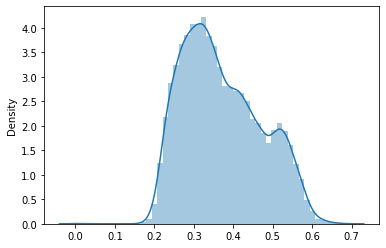

In [1235]:
sns.distplot(pureg.transform(df).max(1))

c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

membership
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
5    AxesSubplot(0.125,0.125;0.775x0.755)
6    AxesSubplot(0.125,0.125;0.775x0.755)
7    AxesSubplot(0.125,0.125;0.775x0.755)
8    AxesSubplot(0.125,0.125;0.775x0.755)
9    AxesSubplot(0.125,0.125;0.775x0.755)
Name: y, dtype: object

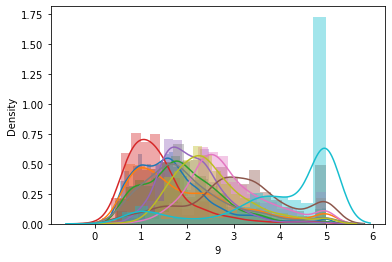

In [1236]:
embs = pureg.transform(df)
point_membership = pd.DataFrame(embs.argmax(1))
point_membership.columns = ['membership']
point_membership['y'] = df[target]
point_membership.groupby('membership')['y'].apply(lambda x: sns.distplot(x))

c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

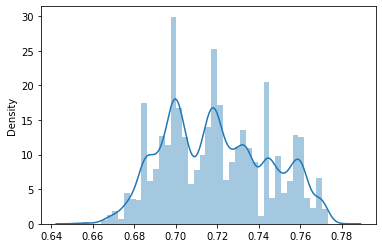

In [1232]:
from sklearn.preprocessing import normalize
sns.distplot(normalize(embs, norm = 'l1').max(1))

c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


c:\users\user ambev\desktop\mypackages\replan\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

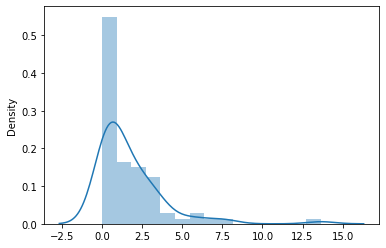

In [990]:
import seaborn as sns
sns.distplot(np.abs(clf.coef_).sum(0))

In [916]:
class RePLAN():
    def __init__(self,)

SyntaxError: invalid syntax (4066236159.py, line 2)